### Let's play with LSTM's
In this notebook I will explore lstms for the task of time seq generation. Time sequence generation is a really important task in robotics, especially if you are dealing with trajectory predictions. 

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#### Generating a sine wave
We will want our network to learn a sine wave. For that we will need to generate multiple sequences of a sine wave. 

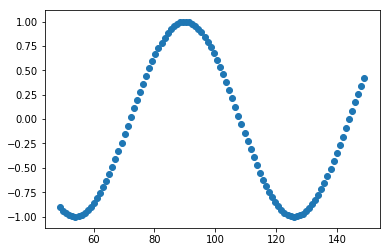

In [270]:
def generate_sample(batch_size = 2, seqlength = 100, show_plot=False,freq=5):
    lower = np.random.randint(-100, 100, size=batch_size)
    higher = lower + seqlength
    x = np.linspace(lower, higher, seqlength).T
    y = np.sin((x * np.pi/180*freq))
    if show_plot:
        plt.scatter(x[1], y[1])
        plt.show()
    return torch.from_numpy(y).float()

input = generate_sample(show_plot=True)

#### Defining Network Related Stuff

In [205]:
epochs = 10
num_samples = 10
batch_size = 10
seqlength = 1000

#### Defining the LSTM model 
We will use two stacked lstm for this task. 
Be careful while using reshape. 

In [206]:
class network(nn.Module):
    def __init__(self, hidden_size=51):
        super(network, self).__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTMCell(input_size=1, hidden_size=self.hidden_size)
        self.lstm2 = nn.LSTMCell(input_size=self.hidden_size, hidden_size=self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, 1)
        self.sig = nn.Sigmoid()
    
    def forward(self, input, future = 0):
        outputs = []
        batch_size = input.shape[0]
        seqlength = input.shape[1]
        ct1 = torch.zeros((batch_size, self.hidden_size))
        ht1 = torch.zeros((batch_size, self.hidden_size))
        ct2 = torch.zeros((batch_size, self.hidden_size))
        ht2 = torch.zeros((batch_size, self.hidden_size))
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            ht1, ct1 = self.lstm1(input_t, (ht1, ct1))
            ht2, ct2 = self.lstm2(ht1, (ht2, ct2))
            out = self.linear(ht2)
            outputs += [out]
            
        for i in range(future):
            ht1, ct1 = self.lstm1(out, (ht1, ct1))
            ht2, ct2 = self.lstm2(ht1, (ht2, ct2))
            out = self.linear(ht2)
            outputs += [out]
        
        
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

#### Loss and Optimizers

In [228]:
np.random.seed(0)
torch.manual_seed(0)
net = network()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

torch.Size([97, 999])
torch.Size([97, 999])
(999,)


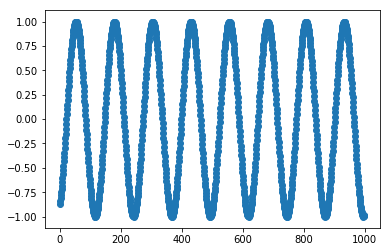

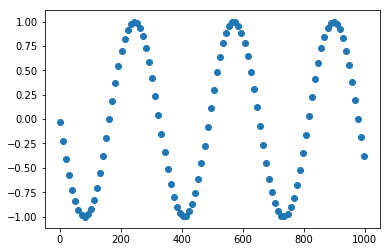

torch.Size([100, 100])


In [310]:
# Loading the data from the sequence we generated #
data = torch.load('traindata.pt')
input = torch.from_numpy(data[3:, :-1])
target = torch.from_numpy(data[3:, 1:])
test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])

print(input.shape)
print(target.shape)
print(np.linspace(1, 999, 999).shape)
plt.scatter(np.linspace(1,999, 999), input[0])
plt.show()

data1 = [generate_sample(batch_size=100, freq=i+1) for i in range(1,11)]
plt.scatter(np.linspace(1,999, 100), data1[9][0])
plt.show()
print(data1[9].shape)

#### Train the network!

In [311]:

for i in range(200):
    tl = 0
    for i in range(10):
        input = data1[i]
        def closure():
            optimizer.zero_grad()
            target = input[:, 1:]
            output = net(input[:, :-1].float())

            loss = criterion(output, target.float())
            print("loss: ", loss.item())
            loss.backward()
            return loss
        optimizer.step(closure)
    print("Epoch : ", i, " Loss : ", tl)

loss:  0.00015037432604003698
loss:  0.00012585820513777435
loss:  0.00043719011591747403
loss:  0.0008079385734163225
loss:  0.0010312035446986556
loss:  0.001058110618032515
loss:  0.0008027899893932045
loss:  0.0004171955515630543
loss:  0.00041365346987731755
loss:  0.00077403848990798
Epoch :  9  Loss :  0
loss:  0.0033597336150705814
loss:  0.0018296934431418777
loss:  0.0031078297179192305
loss:  0.00515597453340888
loss:  0.002980611054226756
loss:  0.0009271514718420804
loss:  0.002147427760064602
loss:  0.0018195920856669545
loss:  0.0019174126209691167
loss:  0.0018116348655894399
Epoch :  9  Loss :  0
loss:  0.003693225095048547
loss:  0.0005153244128450751
loss:  0.0008608383941464126
loss:  0.003679846879094839
loss:  0.0035642848815768957
loss:  0.0011299025500193238
loss:  0.00024639340699650347
loss:  0.0013157457578927279
loss:  0.002116648480296135
loss:  0.0014651656383648515
Epoch :  9  Loss :  0
loss:  0.0055897836573421955
loss:  0.002649373607710004
loss:  0.000

loss:  0.0002174382098019123
loss:  0.0002206997014582157
loss:  0.00020960015535820276
loss:  0.0002321642095921561
loss:  0.0003200367500539869
loss:  0.0004764691402669996
loss:  0.0006113465642556548
Epoch :  9  Loss :  0
loss:  0.00010519857460167259
loss:  0.00017456717614550143
loss:  0.00021523692703340203
loss:  0.00021281887893565
loss:  0.00021840905537828803
loss:  0.00020776128803845495
loss:  0.00022846250794827938
loss:  0.00031323227449320257
loss:  0.0004680967831518501
loss:  0.0006025521433912218
Epoch :  9  Loss :  0
loss:  0.00010082327935378999
loss:  0.0001662800641497597
loss:  0.00020669495279435068
loss:  0.00020668098295573145
loss:  0.00021499366266652942
loss:  0.00020584004232659936
loss:  0.0002251104306196794
loss:  0.00030687794787809253
loss:  0.0004592810873873532
loss:  0.0005924584693275392
Epoch :  9  Loss :  0
loss:  9.794851212063804e-05
loss:  0.00016032876737881452
loss:  0.00019944444647990167
loss:  0.00020062718249391764
loss:  0.00021094825

loss:  0.00013359016156755388
loss:  0.00014201026351656765
loss:  0.00017995563393924385
loss:  0.0001710513752186671
loss:  0.0002133153611794114
loss:  0.00025343470042571425
loss:  0.0003674968611449003
loss:  0.0004661687707994133
Epoch :  9  Loss :  0
loss:  5.628883445751853e-05
loss:  0.0001352383114863187
loss:  0.00013509299606084824
loss:  0.00013764608593191952
loss:  0.00018013316730502993
loss:  0.00017008648137561977
loss:  0.00021015811944380403
loss:  0.0002543934970162809
loss:  0.0003633785527199507
loss:  0.00046382061555050313
Epoch :  9  Loss :  0
loss:  5.3640374972019345e-05
loss:  0.00012984126806259155
loss:  0.00013649332686327398
loss:  0.00013347312051337212
loss:  0.000179227878106758
loss:  0.0001698497508186847
loss:  0.00020620730356313288
loss:  0.00025513305445201695
loss:  0.00035975134233012795
loss:  0.00046062649926170707
Epoch :  9  Loss :  0
loss:  5.16843210789375e-05
loss:  0.0001232985086971894
loss:  0.000137335155159235
loss:  0.00012981615

loss:  8.738076576264575e-05
loss:  0.0001013546425383538
loss:  9.699744987301528e-05
loss:  0.0001353035040665418
loss:  0.0001619273389223963
loss:  0.00018382268899586052
loss:  0.00022058903414290398
loss:  0.000316139601636678
loss:  0.00039094770909287035
Epoch :  9  Loss :  0
loss:  5.078438698546961e-05
loss:  8.854135376168415e-05
loss:  0.00010124390246346593
loss:  9.592616697773337e-05
loss:  0.00013457571913022548
loss:  0.00016228425374720246
loss:  0.00018428018665872514
loss:  0.000219862544327043
loss:  0.0003144563233945519
loss:  0.0003892789245583117
Epoch :  9  Loss :  0
loss:  5.21268775628414e-05
loss:  8.993011579150334e-05
loss:  0.00010129522706847638
loss:  9.48972738115117e-05
loss:  0.00013388734078034759
loss:  0.00016276529640890658
loss:  0.00018489050853531808
loss:  0.0002192188985645771
loss:  0.0003127792151644826
loss:  0.00038765944191254675
Epoch :  9  Loss :  0
loss:  5.361954390536994e-05
loss:  9.15399068617262e-05
loss:  0.0001015145608107559

loss:  6.612607830902562e-05
loss:  0.00011070015898440033
loss:  0.00011141425784444436
loss:  8.638541476102546e-05
loss:  0.00012076299753971398
loss:  0.00016580654482822865
loss:  0.00019928453548345715
loss:  0.0002199697628384456
loss:  0.00028684415156021714
loss:  0.0003516421711537987
Epoch :  9  Loss :  0
loss:  6.582455534953624e-05
loss:  0.00011064967111451551
loss:  0.00011165966861881316
loss:  8.641429303679615e-05
loss:  0.00012031910591758788
loss:  0.00016540524666197598
loss:  0.00019936026365030557
loss:  0.00022014282876625657
loss:  0.0002862763940356672
loss:  0.00035031960578635335
Epoch :  9  Loss :  0
loss:  6.550051330123097e-05
loss:  0.00011055759387090802
loss:  0.00011187873315066099
loss:  8.645244088256732e-05
loss:  0.00011989054473815486
loss:  0.00016498543845955282
loss:  0.00019939684716518968
loss:  0.00022030317632015795
loss:  0.00028573436429724097
loss:  0.00034902169136330485
Epoch :  9  Loss :  0
loss:  6.515227869385853e-05
loss:  0.00011

KeyboardInterrupt: 

torch.Size([1, 200])


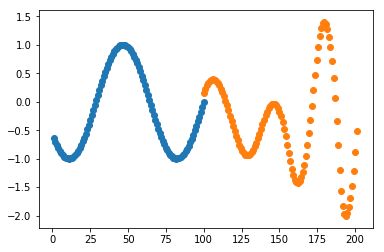

In [317]:
testseqlength=100
test = generate_sample(batch_size=1,seqlength=testseqlength,freq=5)
future=100
out = net(test,future)
print(out.shape)
plt.scatter(np.linspace(1, testseqlength, testseqlength), test.detach().numpy()[0])
# plt.scatter(np.linspace(1, testseqlength, testseqlength),out.detach().numpy()[0,:testseqlength])
plt.scatter(np.linspace(testseqlength, testseqlength+future+1, future), out.detach().numpy()[0,testseqlength:])

In [283]:
torch.save(net.state_dict(), 'model.pth')